In [104]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency, ttest_ind, mannwhitneyu


Importar datos

In [105]:
df = pd.read_csv("incident_event_log.csv")

Limpieza de datos para problemas 1 y 3:

In [106]:
#identificar duplicados

no_duplicados = df.duplicated().value_counts()
no_duplicados
df.shape


(141712, 36)

In [107]:
#Encontrar vacios 
df.isna().sum()

number                     0
incident_state             0
active                     0
reassignment_count         0
reopen_count               0
sys_mod_count              0
made_sla                   0
caller_id                  0
opened_by                  0
opened_at                  0
sys_created_by             0
sys_created_at             0
sys_updated_by             0
sys_updated_at             0
contact_type               0
location                   0
category                   0
subcategory                0
u_symptom                  0
cmdb_ci                    0
impact                     0
urgency                    0
priority                   0
assignment_group           0
assigned_to                0
knowledge                  0
u_priority_confirmation    0
notify                     0
problem_id                 0
rfc                        0
vendor                     0
caused_by                  0
closed_code                0
resolved_by                0
resolved_at   

Al comparar el número de columnas en el data frame y los no duplicasos el resultado es el mismo, no hay duplicados en este. De igual manera, no hay vacios en los datos

In [108]:
#Sacar variables irrelevantes del data frame para los problemas 1 y 3:

df_limpio_1y2 = df
df_limpio_1y2 = df_limpio_1y2.drop(["number","caller_id","opened_by","sys_created_by","sys_updated_by","assignment_group","assigned_to",
                                   "vendor","problem_id","rfc","caused_by","cmdb_ci","resolved_by","closed_code"], axis=1)

Acá se sacan aquellas variables qu solo cumplen la función de identificar el problema a la hora del registro, debiso a que son identificadores son valores únicos para cada uno de los casos y por lo tanto no vale la pena tenerlos en cuenta en el modelo

In [109]:
df_limpio_1y2 = df_limpio_1y2.drop(["resolved_at","closed_at","sys_updated_at","u_symptom"], axis= 1)



Se eliminan variables que conocemos después de que se resuelva el incidente, pues cuando es resuelto el incidente sabemos si se cumplio o no con el SLA, no vale la pena introducir variables a las cuales se les otorga valor después de conocer el resultado de SLA

In [110]:
#Prueba de significancia para evaluar que variables vale la pena dejar:

def pruebas_significancia(df, target="made_sla"):
    resultados = []
    
    columnas_continuas = df.select_dtypes(include=["int64", "float64"]).columns.drop(target, errors="ignore")
    columnas_categoricas = df.select_dtypes(include=["object", "category"]).columns

    for i in columnas_categoricas:
        try:
            tabla = pd.crosstab(df[i], df[target])
            chi2, p, dof, exp = chi2_contingency(tabla)
            resultados.append({"variable": i, "p_valor": p})
        except Exception as e:
            resultados.append({"variable": i, "p_valor": None})

    for j in columnas_continuas:
        grupo1 = df[df[target]==1][j].dropna()
        grupo0 = df[df[target]==0][j].dropna()

        t, p_t = ttest_ind(grupo1, grupo0, equal_var=False, nan_policy="omit")
        resultados.append({"variable": j, "p_valor": p_t})


    return pd.DataFrame(resultados)
resultados = pruebas_significancia(df=df_limpio_1y2)
no_significativas = resultados[resultados["p_valor"] > 0.05]
print("Variables no significativas:", no_significativas["variable"].tolist())



Variables no significativas: ['opened_at', 'sys_created_at']


En este codigo se realizan pruebas de significancia individual para identificar aquellas variables con algun tipo de impacto en la variable de interés, se saca una lista con las no significativas para eliminarlas del data frame pues el hecho de que no sean significativas nos indica que no estan relacionadas con la variable a predecir y por ende no deben ser tomadas en cuenta. 

In [111]:
#Eliminar variables no significativas del data frame: 

df_limpio_1y2 = df_limpio_1y2.drop(["opened_at", "sys_created_at"], axis=1)


Identificar datos aberrantes:

In [112]:
contador_impact = ((df_limpio_1y2["impact"].str[0].astype(int) > 3) | (df_limpio_1y2["impact"].str[0].astype(int) < 1)).sum()
contador_urgency = ((df_limpio_1y2["urgency"].str[0].astype(int) > 3) | (df_limpio_1y2["urgency"].str[0].astype(int) < 1)).sum()
contador_priority = ((df_limpio_1y2["priority"].str[0].astype(int) > 5) | (df_limpio_1y2["priority"].str[0].astype(int) < 1)).sum()
contador_rea_count = ((df_limpio_1y2["reassignment_count"] < 0)).sum()
contador_reo_count= ((df_limpio_1y2["reopen_count"] < 0)).sum()
contador_sys_mod = ((df_limpio_1y2["sys_mod_count"] < 0)).sum()
print(contador_impact,contador_urgency, contador_priority, contador_rea_count, contador_reo_count, contador_sys_mod)

0 0 0 0 0 0


En impacto, urgencia y prioridad no hay datos aberrantes ya que todos se encuentran en los rangos de valores establecidos. De igual manera, en las variables que cuentan sucesos no hay datos aberrantes ya que no hay ningun valor menor a cero, que aería insensato.

identificar datos atipicos en continuas:

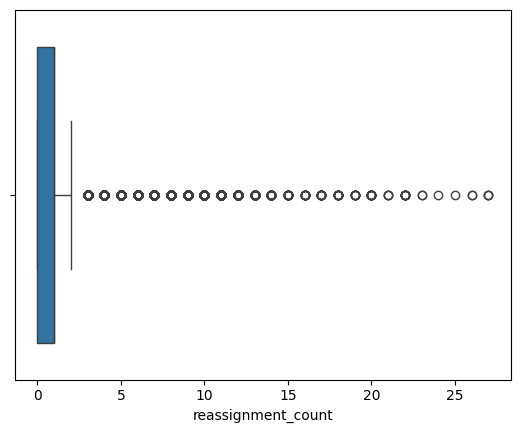

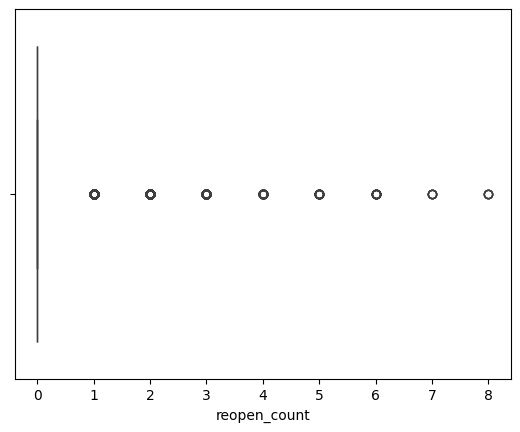

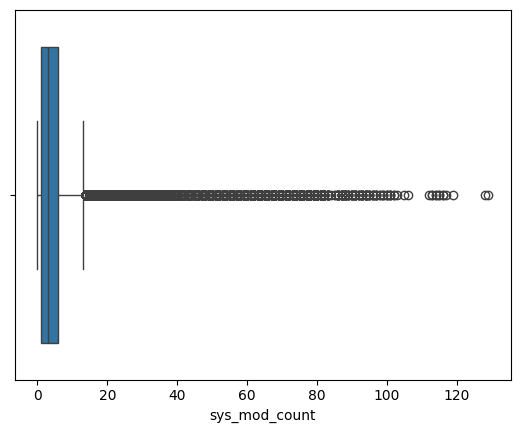

In [113]:
sns.boxplot(x=df_limpio_1y2["reassignment_count"])
plt.show()

sns.boxplot(x=df_limpio_1y2["reopen_count"])
plt.show()

sns.boxplot(x=df_limpio_1y2["sys_mod_count"])
plt.show()

Estas graficas nos muestran que hay ciertos datos atipicos en los contadores, sin embrago no vale la pena eliminarlos pues son valores que es posible qu esucedan a pesar de que se vean alejados de la media.

Datos atípicos para categoricas:

In [114]:
columnas_categoricas = df_limpio_1y2.select_dtypes(include=["object", "category"]).columns
for i in columnas_categoricas:
    print(f"\nCategorías raras en {i}:")
    print(df_limpio_1y2[i].value_counts()[df_limpio_1y2[i].value_counts() < 5])


Categorías raras en incident_state:
Series([], Name: count, dtype: int64)

Categorías raras en contact_type:
Series([], Name: count, dtype: int64)

Categorías raras en location:
location
Location 94     4
Location 95     4
Location 123    4
Location 194    4
Location 134    4
Location 13     4
Location 101    4
Location 130    4
Location 141    3
Location 207    3
Location 211    3
Location 106    3
Location 227    3
Location 137    3
Location 53     3
Location 202    3
Location 164    3
Location 178    3
Location 89     3
Location 181    3
Location 166    2
Location 31     2
Location 132    2
Name: count, dtype: int64

Categorías raras en category:
category
Category 15    3
Category 12    3
Category 36    2
Category 49    2
Category 27    2
Category 3     1
Name: count, dtype: int64

Categorías raras en subcategory:
subcategory
Subcategory 97     4
Subcategory 211    4
Subcategory 87     4
Subcategory 14     4
Subcategory 131    4
Subcategory 95     3
Subcategory 141    3
Subcategory

En las categoricas podemos ver que solo hay zonas que cuentan con menos de 5 datos que pertenecen a ellas, estas no se pueden eliminar ya que el hecho de que no se encuentren casi ubicaciones en ellas no lo hace un valor que no sea valido, pero si son categorias atipicas. 

Convertir categoricas en dummies para un manejo adecuado en el modelo:

In [115]:
#Convertir columnas categoricas en dummies:

df_limpio_1y2 = pd.get_dummies(df_limpio_1y2, columns= columnas_categoricas)


Se convierten las columnas categoricas en variables dummies para después hacer un manejo de los datos adecuado, si les damos valores arbitrarios se pueden inflar los parametros a estimar, por esto es mejor tener dummies.

Preparación de datos problema 2:

No se busacan vacios ni duplicados ya que eso ya se hizo al inicio de este codigo para todo el data frame

In [116]:
df_problema_2 = df[["impact","location"]]

crear un data frame que contenga unicamente las columnas de interes

In [117]:
#Buscar datos aberrantes: 
contador_impact_prob2 = ((df_problema_2["impact"].str[0].astype(int) > 3) | (df_problema_2["impact"].str[0].astype(int) < 1)).sum()
print(contador_impact_prob2)

0


No hay datos por fuera de las categorias establecidas para el impact, se puede decir que no hay datos aberrantes en el impacto 

In [118]:
columnas = df_problema_2.columns
for i in columnas:
    print(f"\nCategorías raras en {i}:")
    print(df_problema_2[i].value_counts()[df_problema_2[i].value_counts() < 5])


Categorías raras en impact:
Series([], Name: count, dtype: int64)

Categorías raras en location:
location
Location 94     4
Location 95     4
Location 123    4
Location 194    4
Location 134    4
Location 13     4
Location 101    4
Location 130    4
Location 141    3
Location 207    3
Location 211    3
Location 106    3
Location 227    3
Location 137    3
Location 53     3
Location 202    3
Location 164    3
Location 178    3
Location 89     3
Location 181    3
Location 166    2
Location 31     2
Location 132    2
Name: count, dtype: int64


Solo hay datos atipicos para las ubicaciones, pues bastentes presentan frecuencias muy bajas. 

In [120]:
#Agrupar lactions poco comunes:

maximo = 5
for i in columnas:
    conteos = df_problema_2[i].value_counts()
    poco_comunes = conteos[conteos < maximo].index
    df_problema_2[i] = df_problema_2[i].replace(poco_comunes, "locations poco comunes")

/var/folders/3q/_06f4vwn6mjfb1cnm_130srm0000gn/T/ipykernel_6207/1724665632.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_problema_2[i] = df_problema_2[i].replace(poco_comunes, "locations poco comunes")
/var/folders/3q/_06f4vwn6mjfb1cnm_130srm0000gn/T/ipykernel_6207/1724665632.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_problema_2[i] = df_problema_2[i].replace(poco_comunes, "locations poco comunes")


Para analizar de manera más sencilla los datos se agrupan las locations pcoo comunes en una sola categoria 